# Importing Libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Displaying signatures

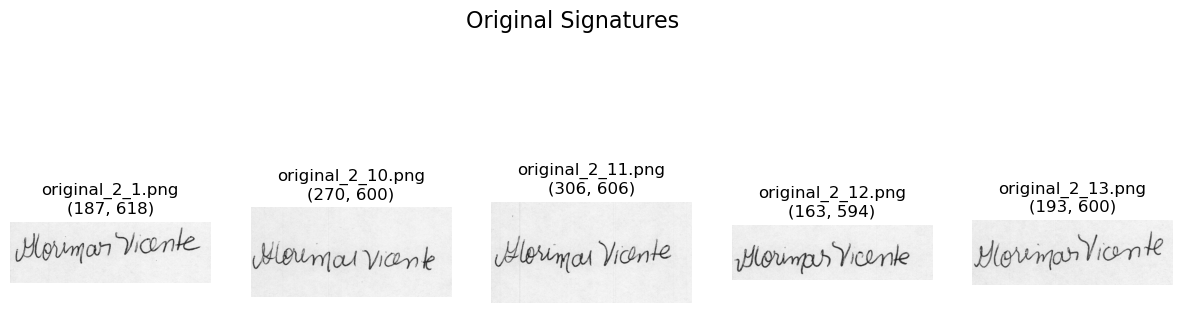

Test Signature Size: (282, 624)


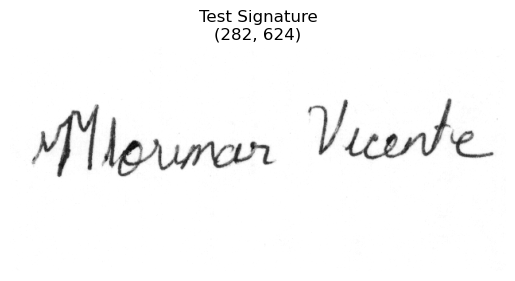

In [8]:
# Path to your dataset
original_signatures_path = "C:/data/dsatm/5th sem/Mini Project/dataset/cedar dataset/trial2/original"  # Update this to your folder path
test_signature_path = "C:/data/dsatm/5th sem/Mini Project/dataset/cedar dataset/trial2/forged/forgeries_2_3.png" # Update this to your test image file path

# Helper function to load images and display their sizes
def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append((img, filename, img.shape))  # Store image, filename, and size
    return images

# Load original and test signatures
original_signatures = load_images_from_folder(original_signatures_path)
test_signature = cv2.imread(test_signature_path, cv2.IMREAD_GRAYSCALE)

# Display some original signatures and their sizes
def display_images_with_sizes(images, title="Original Signatures", rows=1, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5))
    for i in range(min(len(images), rows * cols)):
        img, filename, size = images[i]
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"{filename}\n{size}")
    fig.suptitle(title, fontsize=16)
    plt.show()

# Show samples and their sizes
display_images_with_sizes(original_signatures, title="Original Signatures")
print(f"Test Signature Size: {test_signature.shape if test_signature is not None else 'Not Loaded'}")
plt.imshow(test_signature, cmap='gray')
plt.title(f"Test Signature\n{test_signature.shape if test_signature is not None else 'N/A'}")
plt.axis("off")
plt.show()


# Pre-processing 

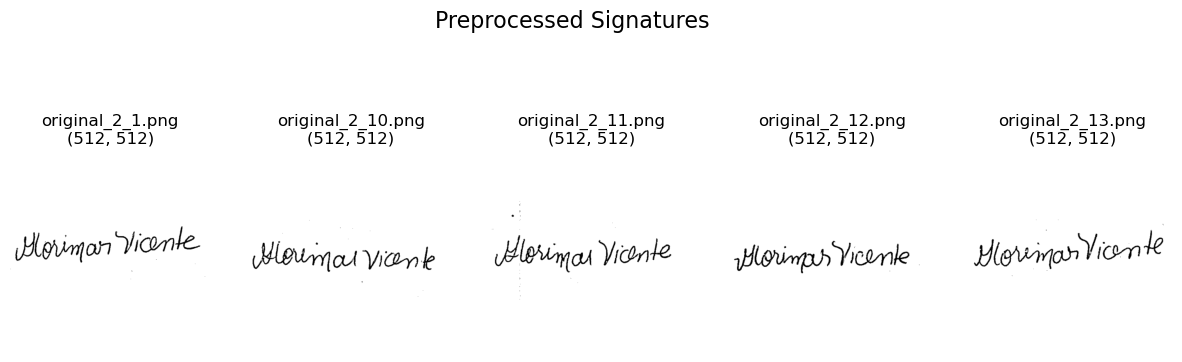

Preprocessed Test Signature Size: (512, 512)


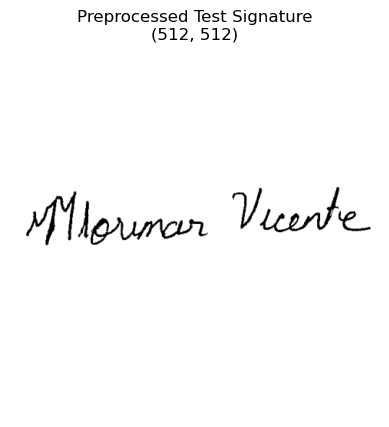

In [9]:
def preprocess_signature(image, resize_dim=(512, 512)):
    """
    Enhanced preprocessing for signature images.
    - Preserves the structure of the signature while standardizing the input format.
    """
    # Convert to grayscale (if not already)
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Bilateral Filter for noise reduction
    filtered_image = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)

    # Adaptive Thresholding for binarization
    binary_image = cv2.adaptiveThreshold(
        filtered_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, blockSize=11, C=2
    )

    # Extract the signature region using contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        # Get bounding box of the largest contour
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))

        # Add padding to the bounding box
        padding = 10
        x = max(0, x - padding)
        y = max(0, y - padding)
        w += 2 * padding
        h += 2 * padding

        cropped_image = binary_image[y:y+h, x:x+w]
    else:
        # If no contours found, use the whole image
        cropped_image = binary_image

    # Resize with aspect ratio preservation
    h, w = cropped_image.shape
    scale = min(resize_dim[0] / h, resize_dim[1] / w)
    new_h, new_w = int(h * scale), int(w * scale)
    resized_image = cv2.resize(cropped_image, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Create a blank canvas and center the resized image
    final_image = np.ones(resize_dim, dtype=np.uint8) * 255  # White background
    y_offset = (resize_dim[0] - new_h) // 2
    x_offset = (resize_dim[1] - new_w) // 2
    final_image[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized_image

    return final_image

# Preprocess dataset
def preprocess_dataset(images):
    """
    Preprocesses a dataset of signature images.
    - Applies preprocessing to each image in the dataset.
    """
    preprocessed_images = []
    for img, filename, original_size in images:
        preprocessed_img = preprocess_signature(img)
        resize = preprocessed_img.shape
        preprocessed_images.append((preprocessed_img, filename, resize))
    return preprocessed_images

preprocessed_original_signatures = preprocess_dataset(original_signatures)
preprocessed_test_signature = preprocess_signature(test_signature)

# Display some preprocessed signatures and their sizes
def display_images_with_sizes(images, title="Preprocessed Signatures", rows=1, cols=5):
    """
    Displays preprocessed signature images with their sizes.
    """
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5))
    for i in range(min(len(images), rows * cols)):
        img, filename, size = images[i]
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"{filename}\n{size}")
    fig.suptitle(title, fontsize=16)
    plt.show()

# Show samples and their sizes
display_images_with_sizes(preprocessed_original_signatures, title="Preprocessed Signatures")
print(f"Preprocessed Test Signature Size: {preprocessed_test_signature.shape if preprocessed_test_signature is not None else 'Not Loaded'}")
plt.imshow(preprocessed_test_signature, cmap='gray')
plt.title(f"Preprocessed Test Signature\n{preprocessed_test_signature.shape if preprocessed_test_signature is not None else 'N/A'}")
plt.axis("off")
plt.show()


# Segmentation

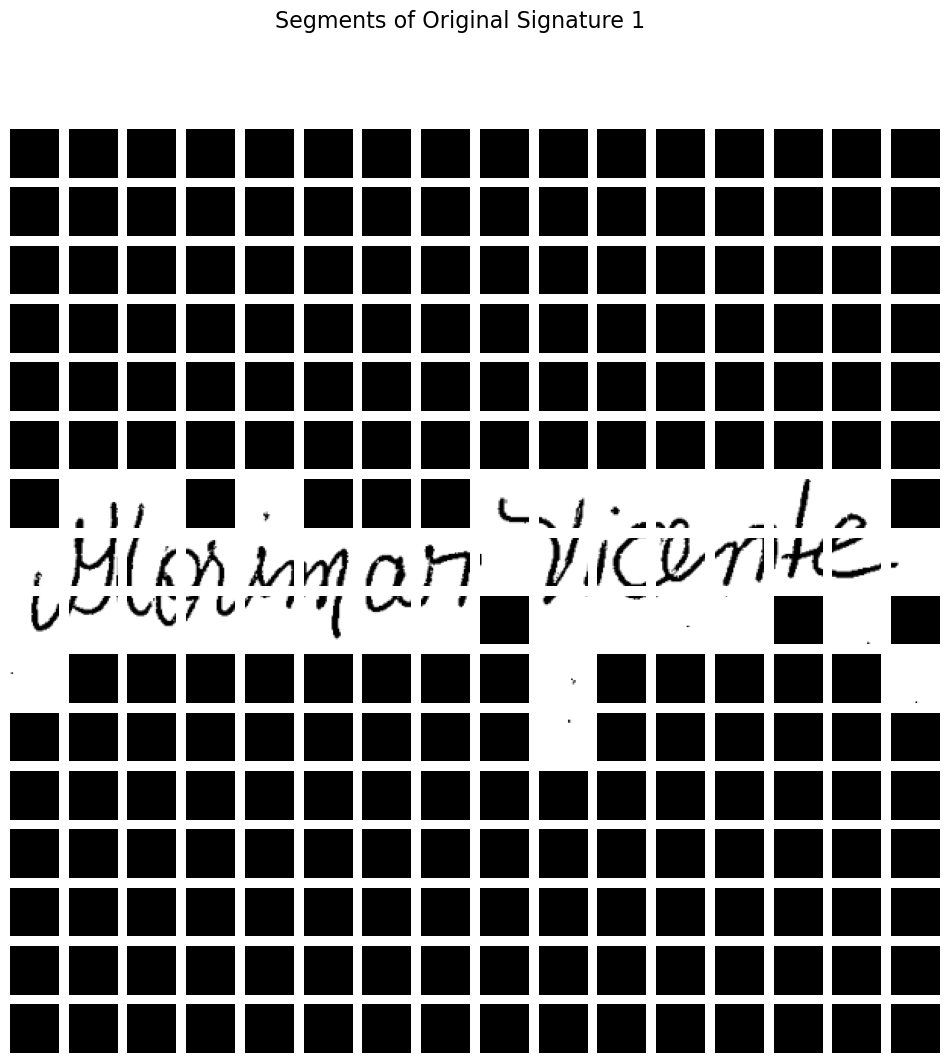

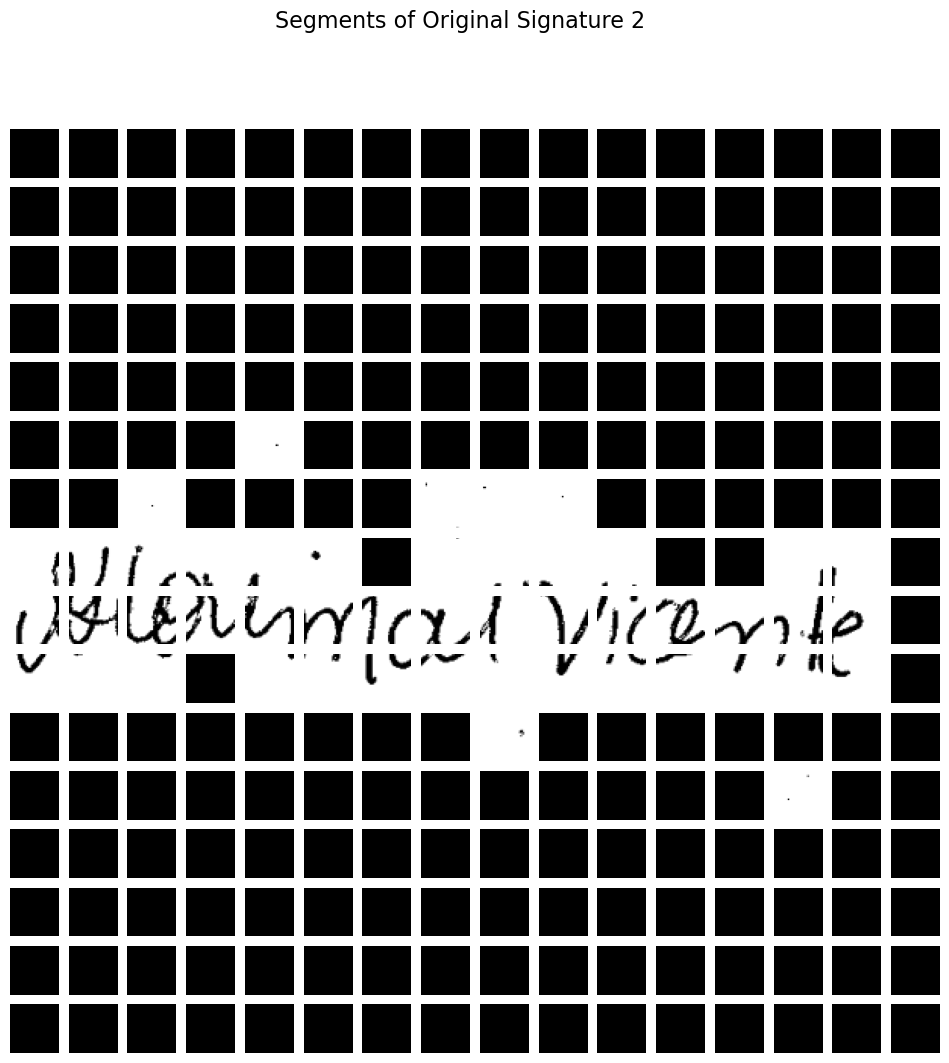

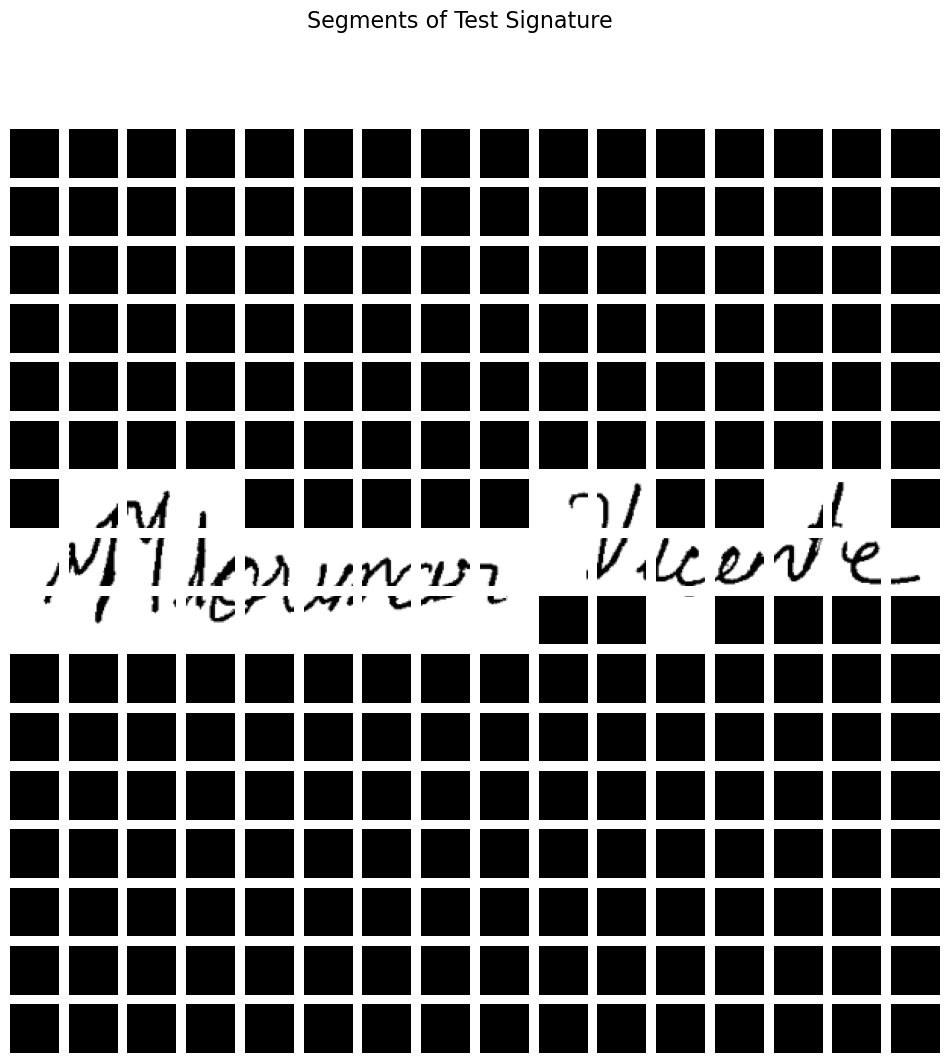

In [10]:
grid_size=(16, 16)
def segment_image(image, grid_size=grid_size):
    h, w = image.shape
    rows, cols = grid_size
    segment_height = h // rows
    segment_width = w // cols
    
    segments = []
    for r in range(rows):
        for c in range(cols):
            segment = image[r * segment_height:(r + 1) * segment_height, c * segment_width:(c + 1) * segment_width]
            segments.append(segment)
    return segments

def segment_dataset(images):
    segmented_images = []
    for img, filename, original_size in images:
        segmented_img = segment_image(img, grid_size=grid_size)
        segmented_images.append(segmented_img)
    return segmented_images

# Segment all preprocessed original signatures with grids
segmented_signatures_16x16 = segment_dataset(preprocessed_original_signatures)

# Segment the preprocessed test signature with grids
segmented_test_signature_16x16 = segment_image(preprocessed_test_signature, grid_size=grid_size)

# Display segments from the first preprocessed original signature
def display_segments(segments, grid_size=grid_size, title="Segments"):
    rows, cols = grid_size
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    for i, ax in enumerate(axes.flat):
        ax.imshow(segments[i], cmap='gray')
        ax.axis('off')
    fig.suptitle(title, fontsize=16)
    plt.show()

# Show segments for the first original signature and the test signature
display_segments(segmented_signatures_16x16[0], grid_size=grid_size, title="Segments of Original Signature 1")
display_segments(segmented_signatures_16x16[1], grid_size=grid_size, title="Segments of Original Signature 2")
display_segments(segmented_test_signature_16x16, grid_size=grid_size, title="Segments of Test Signature")


# Comparison

## Original Comparison

In [5]:
from skimage.metrics import structural_similarity as compare_ssim

# Function to calculate MSE between two segments
def calculate_mse(segment1, segment2):
    return np.mean((segment1.astype("float") - segment2.astype("float")) ** 2)

# Function to calculate SSIM between two segments
def calculate_ssim(segment1, segment2):
    smallest_dim = min(segment1.shape[0], segment1.shape[1])
    win_size = min(7, smallest_dim) if smallest_dim >= 7 else smallest_dim
    if win_size % 2 == 0:  # Ensure win_size is odd
        win_size -= 1
    score, _ = compare_ssim(segment1, segment2, full=True, win_size=win_size)
    return score

# Template Matching Function
def calculate_template_match(segment1, segment2):
    if segment1.shape != segment2.shape:
        segment2 = cv2.resize(segment2, (segment1.shape[1], segment1.shape[0]))
    match_result = cv2.matchTemplate(segment1, segment2, cv2.TM_CCOEFF_NORMED)
    return np.max(match_result)

# Histogram Comparison Function
def calculate_histogram_similarity(segment1, segment2):
    hist1 = cv2.calcHist([segment1], [0], None, [256], [0, 256])
    hist2 = cv2.calcHist([segment2], [0], None, [256], [0, 256])
    hist1 = cv2.normalize(hist1, hist1).flatten()
    hist2 = cv2.normalize(hist2, hist2).flatten()
    score = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
    return score

# Signature Comparison Function
def compare_signature(original_segments_list, test_segments, weights=None, skip_identical=True):
    results = []
    for idx, original_segments in enumerate(original_segments_list):
        if skip_identical and original_segments is test_segments:
            continue
        
        scores = {"mse": [], "ssim": [], "template": [], "histogram": []}
        for i in range(len(original_segments)):
            if np.array_equal(original_segments[i], test_segments[i]):
                continue

            mse_score = calculate_mse(original_segments[i], test_segments[i])
            scores["mse"].append(1 / (1 + mse_score))  # Normalize MSE

            ssim_score = calculate_ssim(original_segments[i], test_segments[i])
            scores["ssim"].append(ssim_score)

            template_score = calculate_template_match(original_segments[i], test_segments[i])
            scores["template"].append(template_score)

            hist_score = calculate_histogram_similarity(original_segments[i], test_segments[i])
            scores["histogram"].append(hist_score)

        mse_avg = np.average(scores["mse"], weights=weights)
        ssim_avg = np.average(scores["ssim"], weights=weights)
        template_avg = np.average(scores["template"], weights=weights)
        histogram_avg = np.average(scores["histogram"], weights=weights)

        results.append({
            "mse_avg": mse_avg,
            "ssim_avg": ssim_avg,
            "template_avg": template_avg,
            "histogram_avg": histogram_avg,
        })
    
    return results

mse_scores, ssim_scores, temp_scores, hist_scores=[],[],[],[]

# Example Usage
for i in range(len(segmented_signatures_16x16)):
    print(f"Comparison with Original Signature {i + 1}")
    comparison_results = compare_signature(
        original_segments_list=segmented_signatures_16x16,
        test_segments=segmented_signatures_16x16[i],  # Replace for meaningful comparisons
        weights=None,
        skip_identical=True
    )

    for idx, result in enumerate(comparison_results):
        print(
            f"Original Signature {idx + 1}: "
            f"MSE = {result['mse_avg']:.4f}, "
            f"SSIM = {result['ssim_avg']:.4f}, "
            f"Template Match = {result['template_avg']:.4f}, "
            f"Histogram = {result['histogram_avg']:.4f}, "
        )

    mse = np.mean([result['mse_avg'] for result in comparison_results])
    ssim = np.mean([result['ssim_avg'] for result in comparison_results])
    temp = np.mean([result['template_avg'] for result in comparison_results])
    hist = np.mean([result['histogram_avg'] for result in comparison_results])

    print(
        f"Average Scores:\n"
        f"MSE: {mse:.4f}, SSIM: {ssim:.4f}, "
        f"Template: {temp:.4f}, Histogram: {hist:.4f}\n"
    )

    mse_scores.append(mse)
    ssim_scores.append(ssim)
    temp_scores.append(temp)
    hist_scores.append(hist)

mse_org_16x16 = np.mean([mse for mse in mse_scores])
ssim_org_16x16 = np.mean([ssim for ssim in ssim_scores])
temp_org_16x16 = np.mean([temp for temp in temp_scores])
hist_org_16x16 = np.mean([hist for hist in hist_scores])
print(f"MSE Score : {mse_org_16x16}, SSIM Score : {ssim_org_16x16}, TM Score : {temp_org_16x16}, Hist Score : {hist_org_16x16}")

Comparison with Original Signature 1
Original Signature 1: MSE = 0.0044, SSIM = 0.5443, Template Match = 0.2971, Histogram = 0.9901, 
Original Signature 2: MSE = 0.0173, SSIM = 0.5506, Template Match = 0.2888, Histogram = 0.9895, 
Original Signature 3: MSE = 0.0045, SSIM = 0.5334, Template Match = 0.2662, Histogram = 0.9844, 
Original Signature 4: MSE = 0.0067, SSIM = 0.5774, Template Match = 0.2906, Histogram = 0.9941, 
Original Signature 5: MSE = 0.0046, SSIM = 0.5084, Template Match = 0.2523, Histogram = 0.9908, 
Original Signature 6: MSE = 0.0091, SSIM = 0.5669, Template Match = 0.2401, Histogram = 0.9973, 
Original Signature 7: MSE = 0.0054, SSIM = 0.4893, Template Match = 0.1332, Histogram = 0.9957, 
Original Signature 8: MSE = 0.0267, SSIM = 0.5389, Template Match = 0.2764, Histogram = 0.9930, 
Original Signature 9: MSE = 0.0141, SSIM = 0.5864, Template Match = 0.2255, Histogram = 0.9981, 
Original Signature 10: MSE = 0.0058, SSIM = 0.5373, Template Match = 0.2967, Histogram = 0

## Forged Comparison

In [11]:
from skimage.metrics import structural_similarity as compare_ssim

# Function to calculate MSE between two segments
def calculate_mse(segment1, segment2):
    return np.mean((segment1.astype("float") - segment2.astype("float")) ** 2)

# Function to calculate SSIM between two segments
def calculate_ssim(segment1, segment2):
    smallest_dim = min(segment1.shape[0], segment1.shape[1])
    win_size = min(7, smallest_dim) if smallest_dim >= 7 else smallest_dim
    if win_size % 2 == 0:  # Ensure win_size is odd
        win_size -= 1
    score, _ = compare_ssim(segment1, segment2, full=True, win_size=win_size)
    return score

# Template Matching Function
def calculate_template_match(segment1, segment2):
    if segment1.shape != segment2.shape:
        segment2 = cv2.resize(segment2, (segment1.shape[1], segment1.shape[0]))
    match_result = cv2.matchTemplate(segment1, segment2, cv2.TM_CCOEFF_NORMED)
    return np.max(match_result)

# Histogram Comparison Function
def calculate_histogram_similarity(segment1, segment2):
    hist1 = cv2.calcHist([segment1], [0], None, [256], [0, 256])
    hist2 = cv2.calcHist([segment2], [0], None, [256], [0, 256])
    hist1 = cv2.normalize(hist1, hist1).flatten()
    hist2 = cv2.normalize(hist2, hist2).flatten()
    score = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
    return score

# Signature Comparison Function
def compare_signature(original_segments_list, test_segments, weights=None, skip_identical=True):
    results = []
    for idx, original_segments in enumerate(original_segments_list):
        if skip_identical and original_segments is test_segments:
            continue
        
        scores = {"mse": [], "ssim": [], "template": [], "histogram": []}
        for i in range(len(original_segments)):
            if np.array_equal(original_segments[i], test_segments[i]):
                continue

            mse_score = calculate_mse(original_segments[i], test_segments[i])
            scores["mse"].append(1 / (1 + mse_score))  # Normalize MSE

            ssim_score = calculate_ssim(original_segments[i], test_segments[i])
            scores["ssim"].append(ssim_score)

            template_score = calculate_template_match(original_segments[i], test_segments[i])
            scores["template"].append(template_score)

            hist_score = calculate_histogram_similarity(original_segments[i], test_segments[i])
            scores["histogram"].append(hist_score)

        mse_avg = np.average(scores["mse"], weights=weights)
        ssim_avg = np.average(scores["ssim"], weights=weights)
        template_avg = np.average(scores["template"], weights=weights)
        histogram_avg = np.average(scores["histogram"], weights=weights)

        results.append({
            "mse_avg": mse_avg,
            "ssim_avg": ssim_avg,
            "template_avg": template_avg,
            "histogram_avg": histogram_avg,
        })
    
    return results

comparison_results = compare_signature(
        original_segments_list=segmented_signatures_16x16,
        test_segments=segmented_test_signature_16x16,  # Replace for meaningful comparisons
        weights=None,
        skip_identical=True
    )

for idx, result in enumerate(comparison_results):
    print(
            f"Original Signature {idx + 1}: "
            f"MSE = {result['mse_avg']:.4f}, "
            f"SSIM = {result['ssim_avg']:.4f}, "
            f"Template Match = {result['template_avg']:.4f}, "
            f"Histogram = {result['histogram_avg']:.4f}, "
        )

mse = np.mean([result['mse_avg'] for result in comparison_results])
ssim = np.mean([result['ssim_avg'] for result in comparison_results])
temp = np.mean([result['template_avg'] for result in comparison_results])
hist = np.mean([result['histogram_avg'] for result in comparison_results])

print(
        f"Average Scores:\n"
        f"MSE: {mse}, SSIM: {ssim}, "
        f"Template: {temp}, Histogram: {hist}\n"
    )


Original Signature 1: MSE = 0.0089, SSIM = 0.5430, Template Match = 0.3294, Histogram = 0.9972, 
Original Signature 2: MSE = 0.0035, SSIM = 0.5479, Template Match = 0.4140, Histogram = 0.9891, 
Original Signature 3: MSE = 0.0155, SSIM = 0.5245, Template Match = 0.3802, Histogram = 0.9876, 
Original Signature 4: MSE = 0.0023, SSIM = 0.5142, Template Match = 0.3592, Histogram = 0.9827, 
Original Signature 5: MSE = 0.0045, SSIM = 0.5293, Template Match = 0.3657, Histogram = 0.9925, 
Original Signature 6: MSE = 0.0027, SSIM = 0.4948, Template Match = 0.3719, Histogram = 0.9895, 
Original Signature 7: MSE = 0.0070, SSIM = 0.5691, Template Match = 0.3719, Histogram = 0.9968, 
Original Signature 8: MSE = 0.0030, SSIM = 0.4778, Template Match = 0.2905, Histogram = 0.9941, 
Original Signature 9: MSE = 0.0421, SSIM = 0.5291, Template Match = 0.4023, Histogram = 0.9910, 
Original Signature 10: MSE = 0.0140, SSIM = 0.5520, Template Match = 0.3429, Histogram = 0.9962, 
Original Signature 11: MSE = 